In [1]:
import numpy as np
from pathlib import Path
from scipy.optimize import curve_fit

from pyFAI.multi_geometry import MultiGeometry
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator as AzInt
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def load_image(imageFullname):
    """
    author: Fang Ren (SSRL), Robert Tang-Kong
    version: 1.1

    returns: nppy array with image data
    CURRENTLY HARD CODED FOR PILATUS
    """
    # get extension to consider
    ext = os.path.splitext(imageFullname)[1]
    #print(imageFullname)
    imArray = np.array([])
    if ext.lower() in ['.tif', '.tiff']:
        # open tiff image
        im = fabio.open(imageFullname)
        # input image object into a nppy array
        imArray = im.data
    elif ext.lower() in ['.raw']:
        # extract raw file
        im = open(imageFullname, 'rb')
        arr = np.fromstring(im.read(), dtype='int32')
        im.close()

        #raw requires prompting for dimensions, hard code for now
        arr.shape = (195, 487)
        imArray = np.array(arr)

    return imArray

def simple_line(x, m, b):
    return m*x + b

def gauss_linbkg(x, m, b, x0, intint, fwhm):
    return m*x + b + intint*(2./fwhm)*np.sqrt(np.log(2.)/np.pi)*np.exp(-4.*np.log(2.)*((x-x0)/fwhm)**2)

def Gauss_fit(x, y):
    pguess = [0, 0, np.argmax(y), np.max(y), 5.0]  # linear background (2), pos, intensity, fwhm
    popt, pcov = curve_fit(gauss_linbkg, x, y, p0=pguess)
    return popt

# Beam calibration
Calculates and records direct beam position and detector distance

In [3]:
# Organize paths and collect images to integrate
base_path = Path('C:\\Users\\roberttk\\Desktop\\SLAC_RA\\DATA\\July2021_Xiaolin\\calibration\\')
exportPath = base_path / 'export'
specPath = base_path # folder holding spec files

specFiles = specPath.glob('*b_scan1.csv') # use re to be more precise
specs = [pd.read_csv(x, index_col=0).rename(columns=lambda x: x.strip()) for x in specFiles]
user = 'b_mehta_'
imgPath = specPath / 'images'

# define detector.  
from pyFAI.detectors import Pilatus100k
det = Pilatus100k()

# define detector geometry
# USER MUST CHANGE THIS VALUE
centerPx1, centerPx2 = (91, 277)

C:\Users\roberttk\Desktop\SLAC_RA\DATA\July2021_Xiaolin\calibration\images\b_mehta_directbeam_07262021_b_scan1_0000.raw


<ipython-input-2-39974688f8ee>:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(im.read(), dtype='int32')


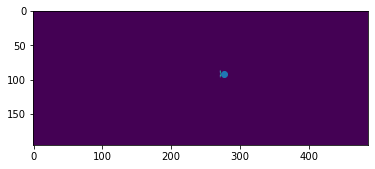

In [7]:
imgs = imgPath.glob('*b_scan1*.raw')

for im_fp in imgs:
    print(im_fp)
    data = load_image(im_fp)
    plt.imshow(data)
    plt.scatter(centerPx2, centerPx1)
    break

<ipython-input-2-39974688f8ee>:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(im.read(), dtype='int32')
<ipython-input-2-39974688f8ee>:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(im.read(), dtype='int32')
<ipython-input-2-39974688f8ee>:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(im.read(), dtype='int32')
<ipython-input-2-39974688f8ee>:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(im.read(), dtype='int32')
<ipython-input-2-39974688f8ee>:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on un

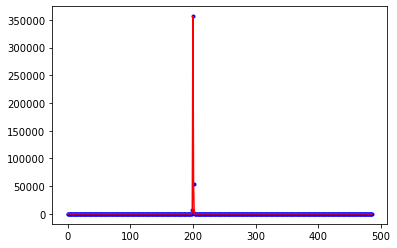

In [8]:
imgs = imgPath.glob('*b_scan1*.raw')

pks = []
plt.figure()
for im_fp in imgs:
    data = load_image(im_fp)
    x = np.arange(0, np.shape(data)[1])
    y = data[centerPx1, :]
    y += data[centerPx1 + 1, :]
    y += data[centerPx1 - 1, :]
    y += data[centerPx1 + 2, :]
    y += data[centerPx1- 2, :]
    popt = Gauss_fit(x, y)
    plt.cla()
    plt.plot(x,y, 'b.')
    plt.plot(x, gauss_linbkg(x, *popt), 'r-')
    pks = np.append(pks, popt[2])

Sample to detector distance in pixels = 8.514111864902949
Sample_Detector_distance_mm =1.4644272407633072e-06


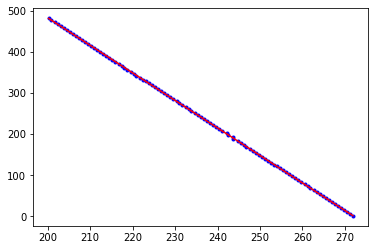

In [9]:
num_points = len(specs[0])
calib_tth_steps = (x[-1] - x[0])/num_points
xx = np.arange(num_points)

lin_fit, pcov = curve_fit(simple_line, pks, xx*calib_tth_steps + 0.00)
# take slope 
det_R = 1.0/np.tan(abs(lin_fit[0])*np.pi/180.0)     # sample to detector distance in pixels
print("Sample to detector distance in pixels = " + str(det_R))
print("Sample_Detector_distance_mm =" + str(det_R * det.pixel1 / 1000.0))
plt.figure()
plt.plot(pks, xx*calib_tth_steps, 'b.')
plt.plot(pks, lin_fit[0]*pks + lin_fit[1], 'r-')

In [ ]:
len(xx)